In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
from scipy import io
from sklearn import metrics

from yass.augment import make
from pathlib import Path
from statsmodels.tsa.stattools import acf
import sklearn_evaluation.plot as skplot

import yass
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage
from yass import set_config, read_config
from yass.templates import TemplatesProcessor
from yass.neuralnetwork.evaluate import Dataset
from yass.neuralnetwork import evaluate
from yass.augment import util as augment_util
from yass.augment import noise as noise_utils
from yass.batch import RecordingsReader

import seaborn as sns
import pandas as pd
from dstools import plot
from keras.models import load_model

Using TensorFlow backend.


In [4]:
from os import path

path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'retinal/groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'retinal/ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

## Load model

In [16]:
# no noise problem
path_to_model = str(Path('~', 'data', 'detect', 'models', '2018-10-03T05-01-43.ckpt').expanduser())

# noise problem
path_to_model = str(Path('~', 'data', 'detect', 'models', '2018-10-03T04-01-32.ckpt').expanduser())
# path_to_model = str(Path('~', 'data', 'detect', 'models', '2018-10-03T04-13-50:detect-61wf7ch.h5').expanduser())

In [17]:
yass.set_config("../../config/gcloud/49/default.yaml", 'tmp')
CONFIG = read_config()

# path_to_model_ref = '/home/Edu/shengao-aug1/detect.ckpt'
# path_to_model_ref = '/home/Edu/cat-july19/detect.ckpt'
# path_to_model = '/home/Edu/dev/private-yass/nnet/models/detect/09-Aug-2018@02-02-17.ckpt'
# path_to_model = '/home/Edu/yass/src/yass/assets/models/detect_nn1.ckpt'
# path_to_model = '/home/Edu/dev/private-yass/nnet/models/detect/16-Aug-2018@00-06-50.ckpt'
# path_to_model = '/home/Edu/dev/private-yass/nnet/models/detect/16-Aug-2018@01-03-37.ckpt'
# path_to_model = 'detect-09-Aug-2018@01-54-51.h5'
# path_to_model = path_to_model_ref
# path_to_model = '/home/Edu/shengao-aug1/detect.ckpt'
# path_to_model = '/home/Edu/shengao-aug1/detect.ckpt'

THRESHOLD = 0.5

model = NeuralNetDetector.load(path_to_model, 0.5, CONFIG.channel_index, load_test_set=True)

# from keras.models import load_model

# model = load_model(path_to_model)

## Evaluation on test set

In [18]:
preds = model.predict(model.x_test)

In [19]:
model.x_test.shape

(16560, 61, 7)

In [20]:
from sklearn import metrics

_ = metrics.confusion_matrix(model.y_test, preds)
cm = _ / _.sum(axis=1)
m = dict()
m['tn'], m['fp'], m['fn'], m['tp'] = [float(_) for _ in cm.flatten()]

In [21]:
m

{'tn': 0.9996032008465049,
 'fp': 0.004169562195969423,
 'fn': 0.0013887970372329873,
 'tp': 0.985406532314107}

In [22]:
cm = metrics.confusion_matrix(model.y_test, preds)
cm
# cm = cm.astype('float') / cm.sum(axis=1)
# m = dict()
# m['tn'], m['fp'], m['fn'], m['tp'] = ['{:.2}'.format(float(_)) for _ in cm.flatten()]
# m

array([[15115,     6],
       [   21,  1418]])

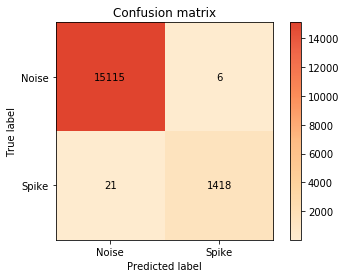

In [23]:
skplot.confusion_matrix(model.y_test, preds, normalize=False, target_names=['Noise', 'Spike'])

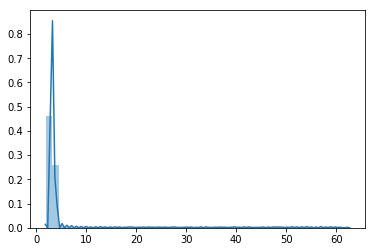

In [24]:
amps = augment_util.amplitudes(model.x_test)
sns.distplot(amps)

In [25]:
test_spike = model.x_test[model.y_test.astype(bool)]
test_noise = model.x_test[~model.y_test.astype(bool)]
test_spike.shape, test_noise.shape

((1439, 61, 7), (15121, 61, 7))

In [26]:
test = np.concatenate((test_spike, test_noise))

In [27]:
test.shape

(16560, 61, 7)

In [28]:
slices = {'from templates': slice(0, test_spike.shape[0]) , 'noise': slice(test_spike.shape[0], test_spike.shape[0]+test_noise.shape[0])}

In [29]:
slices

{'from templates': slice(0, 1439, None), 'noise': slice(1439, 16560, None)}

In [30]:
test[slices['from templates']].shape, test[slices['noise']].shape

((1439, 61, 7), (15121, 61, 7))

In [31]:
d = Dataset(test, slices, 1.0)

## Template loading

In [32]:
uncropped = np.load(Path('~', 'data', 'cat', 'templates-jul27-only-good.npy').expanduser())

In [33]:
processor = TemplatesProcessor(uncropped)

In [34]:
templates = processor.crop_spatially(CONFIG.neigh_channels, CONFIG.geom).values #.crop_temporally(15).values

temporal_size = templates.shape[1]
n_channels = templates.shape[2]

In [35]:
detected_prop = model.predict(templates).mean()
print('Detected templates: %f' % detected_prop)

Detected templates: 1.000000


In [36]:
from yass.geometry import make_channel_index

ch_idx = make_channel_index(CONFIG.neigh_channels, CONFIG.geom)
selected_channels = ch_idx[0]
selected_channels

rec = RecordingsReader(path_to_standarized, loader='array').data[:, selected_channels]

(spatial_sig,
 temporal_sig) = noise_utils.noise_cov(rec, temporal_size, temporal_size)

spatial_sig.shape, temporal_sig.shape

((7, 7), (61, 61))

## Generate testing data

In [37]:
min_amp = 6
max_amp = 60
n_clean_per_template = 200

In [38]:
dataset = Dataset.make(units_per_bin=0.5,
                       include_clean_data=False,
                       templates=templates,
                       min_amplitude=min_amp,
                       max_amplitude=max_amp,
                       n_per_template=n_clean_per_template,
                       spatial_sig=spatial_sig,
                       temporal_sig=temporal_sig,
                       make_from_templates=True,
                       make_spatially_misaligned=True,
                       make_temporally_misaligned=True,
                       make_collided=True,
                       make_noise=True)

In [39]:
dataset.stats

{'from templates': 48000,
 'spatially misaligned': 48000,
 'temporally misaligned': 48000,
 'collided': 48000,
 'noise': 48000}

## Predict on templates

In [40]:
label = 1
data = dataset.get_kind('from templates').data
preds = model.predict(data)
print('Proportion of correct predictions', (preds == label).mean())

wrong = data[preds != label]

Proportion of correct predictions 0.9988958333333333


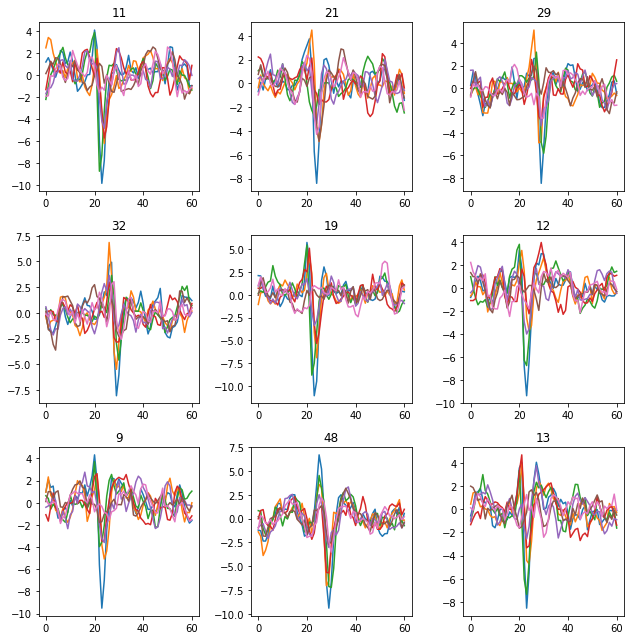

In [41]:
plot.grid_from_array(wrong, elements=9, axis=0, auto_figsize=3)

## Collided

In [401]:
label = 1
data = dataset.get_kind('collided').data
preds = model.predict(data)
# preds = np.squeeze(model.predict(data[:, :, :, np.newaxis]))
print('Proportion of correct predictions', (preds == label).mean())

wrong = data[preds != label]

Proportion of correct predictions 0.9591041666666666


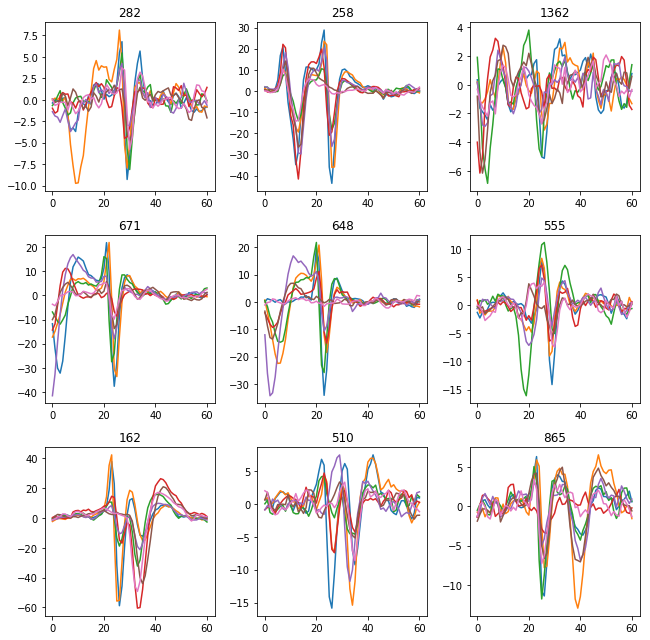

In [402]:
plot.grid_from_array(wrong, elements=9, axis=0, auto_figsize=3)

## Temporally misaligned

In [403]:
label = 0
data = dataset.get_kind('temporally misaligned').data
preds = model.predict(data)
# preds = np.squeeze(model.predict_classes(data[:, :, :, np.newaxis]))
print('Proportion of correct predictions', (preds == label).mean())

wrong = data[preds != label]

Proportion of correct predictions 0.9997291666666667


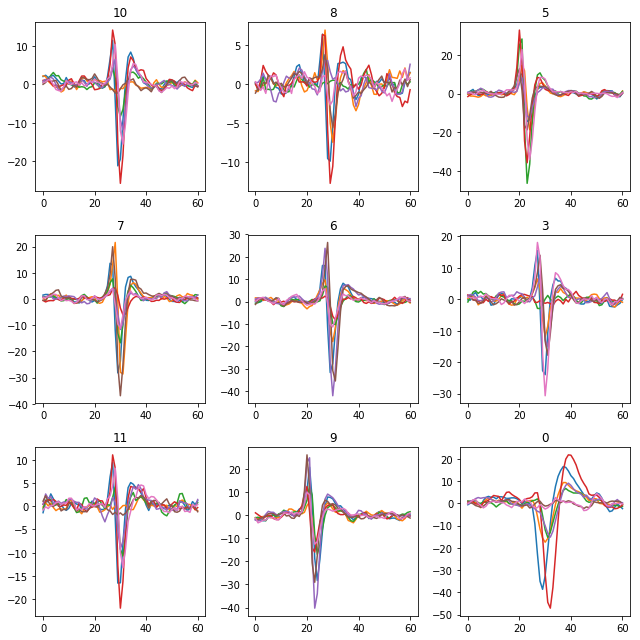

In [404]:
plot.grid_from_array(wrong, elements=9, axis=0, auto_figsize=3)

## Spatially misaligned

In [405]:
label = 0
data = dataset.get_kind('spatially misaligned').data
preds = model.predict(data)
# preds = np.squeeze(model.predict_classes(data[:, :, :, np.newaxis]))
print('Proportion of correct predictions', (preds == label).mean())

wrong = data[preds != label]

Proportion of correct predictions 0.35739583333333336


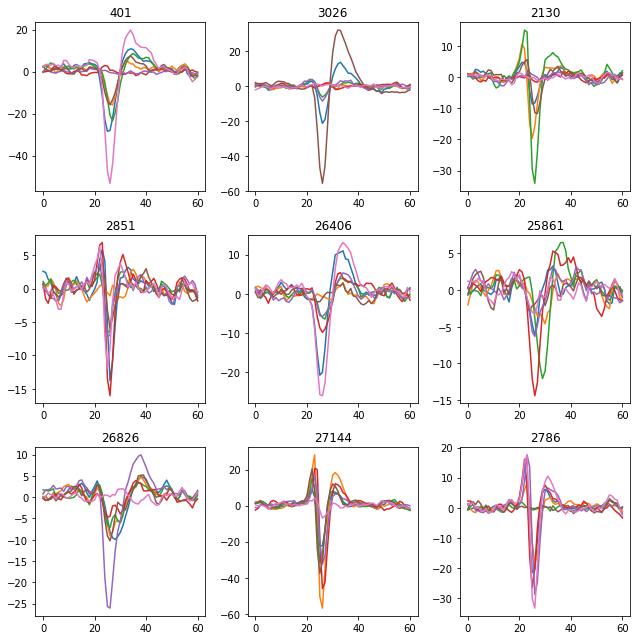

In [406]:
plot.grid_from_array(wrong, elements=9, axis=0, auto_figsize=3)

## Noise

In [42]:
label = 0
data = dataset.get_kind('noise').data
preds = model.predict(data)
# preds = np.squeeze(model.predict_classes(data[:, :, :, np.newaxis]))
print('Proportion of correct predictions', (preds == label).mean())

wrong = data[preds != label]

Proportion of correct predictions 0.9986041375861997


In [43]:
wrong.shape

(67, 61, 7)

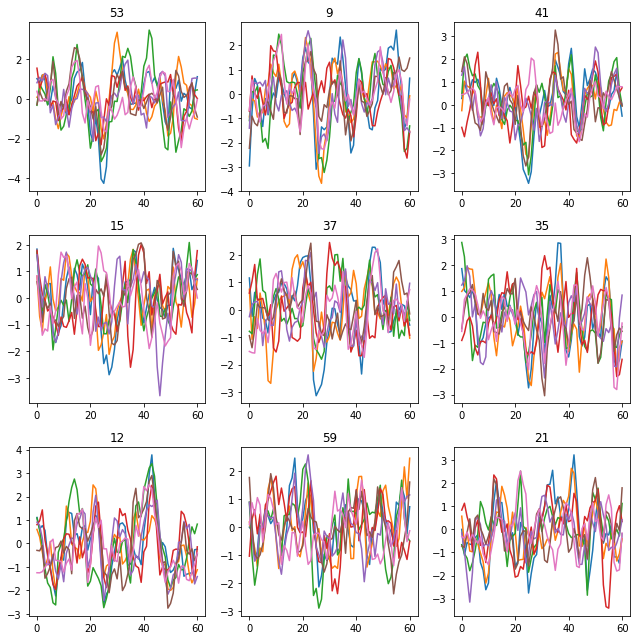

In [44]:
plot.grid_from_array(wrong, elements=9, axis=0, auto_figsize=3)

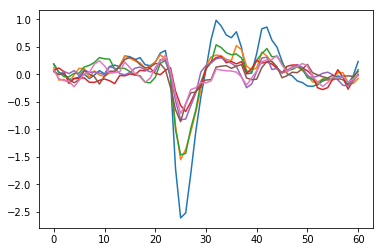

In [47]:
plt.plot(wrong.mean(axis=0))

## Noise evaluation

In [410]:
n_noise = 10000
noise = augment_util.make_noise(n_noise, spatial_sig, temporal_sig)
print('Noise shape:', noise.shape)

Noise shape: (10000, 61, 7)


In [411]:
probas = model.predict_proba(noise)

In [412]:
higher_than_zero = noise[probas > 0.01]
higher_than_one_half = noise[probas > 0.5]

fpr = len(higher_than_one_half)/n_noise

print('{} ({:.4f}) [>0.01], {} ({:.4f})[>0.5]'.format(len(higher_than_zero), len(higher_than_zero)/n_noise,
                                              len(higher_than_one_half), fpr))

2 (0.0002) [>0.01], 0 (0.0000)[>0.5]


In [413]:
plot.grid_from_array(higher_than_one_half,
                     axis=0,
                     auto_figsize=(5, 3),
                     sharey=True,
                     elements=6)

<Figure size 0x0 with 0 Axes>

/home/Edu/miniconda3/envs/yass/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
/home/Edu/miniconda3/envs/yass/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


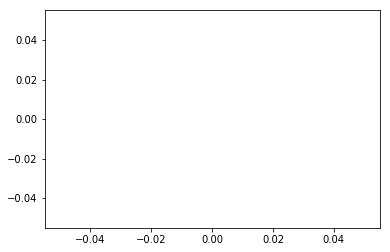

In [414]:
noise_mean_wf = higher_than_one_half.mean(axis=0)
_ = plt.plot(noise_mean_wf)

## Large snippet noise

In [417]:
n_noise = 1
temporal_size = 1000
n_channels = 7

(spatial_sig_large,
 temporal_sig_large) = noise_utils.noise_cov(rec, temporal_size, 61, 100)

In [418]:
noise = augment_util.make_noise(1, spatial_sig_large, temporal_sig_large)[0, :, :]
print('Noise shape:', noise.shape)

Noise shape: (1000, 7)


/home/Edu/yass/src/yass/augment/util.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  noise[:, :, c] = np.matmul(noise[:, :, c], temporal_SIG)


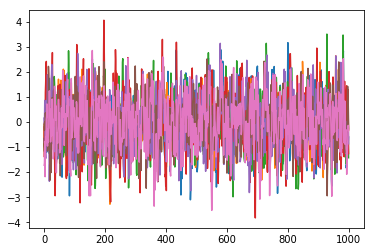

In [419]:
_ = plt.plot(noise)

In [420]:
model.predict_recording(noise)

[array([[ 88,  18],
        [220,   1],
        [263,  16],
        [265,  16],
        [485,  16],
        [554,  18],
        [678,  16],
        [697,   3],
        [697,  15],
        [745,  18],
        [850,  15],
        [891,  16],
        [923,  18],
        [966,  17]], dtype=int32)]

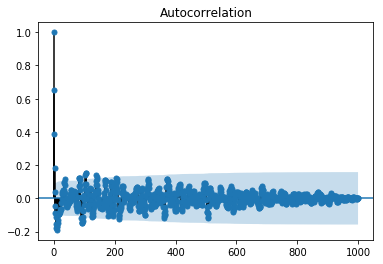

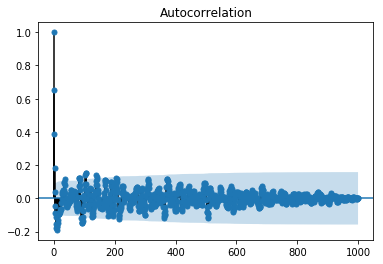

In [123]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(noise[0, :, 4])

In [132]:
import yaml
from yass import detect
from yass.detect import nnet

params = {'data_order': 'samples', 'dtype': noise.dtype, 'n_channels': 49}
noise.tofile('/tmp/noise.bin')

with open('/tmp/noise.yaml', 'w') as f:
        yaml.dump(params, f)

In [133]:
scores, clear, spikes_all = detect.run('/tmp/noise.bin', '/tmp/noise.yaml',
                                       '/home/Edu/data/retinal/sample_output/preprocess/whitening.npy',
                                      function=nnet.run)

FileNotFoundError: [Errno 2] No such file or directory: '/home/Edu/data/retinal/tmp/detect'

In [ ]:
spikes_all.shape

## Misclassified noise with varying amplitudes

In [39]:
noise_df = dataset.get_kind('noise', units_per_bin=0.5).df

# add labels
_ = {'noise': 0}

noise_df['label'] = noise_df.kind.replace(_)

noise_df.head()

,waveform,amplitude,kind,ptp,amplitude_group,ptp_group,label
0,"[[-0.5167180328667593, 0.3528625423030752, -1....",2.287116,noise,3.743737,2.501,4.218,0
1,"[[-0.9781039028627837, -0.7824938165579068, -0...",3.532306,noise,5.018683,5.705,5.071,0
2,"[[-1.5115761869056192, -1.301904977423462, -1....",2.545152,noise,4.946535,2.682,5.071,0
3,"[[0.1359663075964111, -0.920120209009032, -0.1...",1.996428,noise,3.885345,2.501,4.218,0
4,"[[2.0107593248581606, 2.217113874043089, 1.339...",2.234238,noise,4.033950,2.501,4.218,0


/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


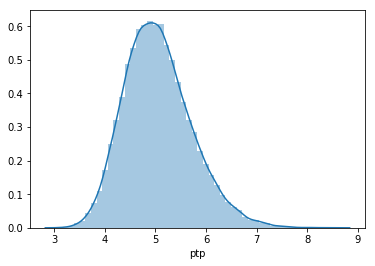

In [40]:
sns.distplot(noise_df.ptp)

In [41]:
def prop(preds, group):
    return (1 - (preds == group.label).mean())

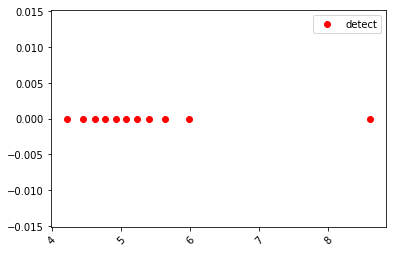

In [42]:
x, y = evaluate.compute_per_group(noise_df, 'ptp_group',
                                  model.predict, prop)

# plot results
# label=model.model_name
_ = plt.scatter(x, y, color='r', label='detect')

_ = plt.legend()
_ = plt.xticks(rotation=45)

## Predict on recordings

## Metrics vs SNR

In [73]:
dataset = d

In [45]:
dataset.get_kind('from templates').data.shape

(21031, 31, 7)

In [46]:
dataset.stats

{'from templates': 21031, 'noise': 31529}

In [47]:
df = dataset.df
df['label'] = df.kind.replace({'from templates': 1, 'noise': 0})
df.head()

,waveform,amplitude,kind,ptp,amplitude_group,ptp_group,label
0,"[[0.985151029204214, -0.16425269331751885, 0.3...",5.900721,from templates,8.229762,6.405,8.421,1
1,"[[2.4827955973046376, -1.834106760667691, 0.07...",46.002637,from templates,65.779038,46.830,66.758,1
2,"[[4.154198977584559, 0.4390342941036155, 3.118...",47.115299,from templates,61.543047,47.831,61.866,1
3,"[[4.336297788158669, -0.7124062981753692, -2.0...",56.721882,from templates,90.558875,57.410,91.661,1
4,"[[1.1412703851738608, 0.38320568115216425, -1....",19.036427,from templates,27.610576,19.202,27.673,1


In [48]:
def mean_tp_prob(preds, group):
    real_ones = group.label.values == 1
    return preds[real_ones].mean()

def mean_tn_prob(preds, group):
    real_zeros = group.label.values == 0
    return preds[real_zeros].mean()

def acc(preds, group):
    return (preds == group.label.values).mean()

def fpr(preds, group):
    real_zeros = group.label.values == 0
    return (preds[real_zeros] == 1).mean()

def fnr(preds, group):
    real_ones = group.label.values == 1
    return (preds[real_ones] == 0).mean()

def tpr(preds, group):
    real_ones = group.label.values == 1
    return (preds[real_ones] == 1).mean()

def tnr(preds, group):
    real_zeros = group.label.values == 0
    return (preds[real_zeros] == 0).mean()

def accuracy(preds, group):
    return metrics.accuracy_score(group.label, preds)

In [49]:
from functools import partial

def predict_w_threshold(x, threshold):
    return model.predict_proba(x) > threshold

predict_ = partial(predict_w_threshold, threshold=THRESHOLD)
# predict_ = model.predict_proba

In [50]:
def plot_metric(metric, title):
    x, y = evaluate.compute_per_group(df,
                         'amplitude_group',
                         model.predict_classes if hasattr(model, 'predict_classes') else model.predict,
                         metric)    
#     x_ref, y_ref = evaluate.compute_per_group(df,
#                          'amplitude_group',
#                          model_ref.predict_classes if hasattr(model_ref, 'predict_classes') else model_ref.predict,
#                          metric)

    min_ = np.min(x)
    max_ = np.max(x)


    plt.figure(figsize=(20, 10))

    _ = plt.scatter(x, y, color='b', label='Detect new architecture')
#     _ = plt.scatter(x_ref, y_ref, color='r', label='Detect reference')

    # _ = plt.hlines(1.0, 2, max_, linestyles='dashed')
    # _ = plt.hlines(0.98, 2, max_, linestyles='dashed')
    # _ = plt.hlines(0.9, 2, max_, linestyles='dashed')
    # _ = plt.vlines(2.5, 0.5, 1, linestyles='dashed')

#     _ = plt.xlim(2, 20)
    _ = plt.title(title)

    _ = plt.legend()
    _ = plt.xticks(rotation=45)

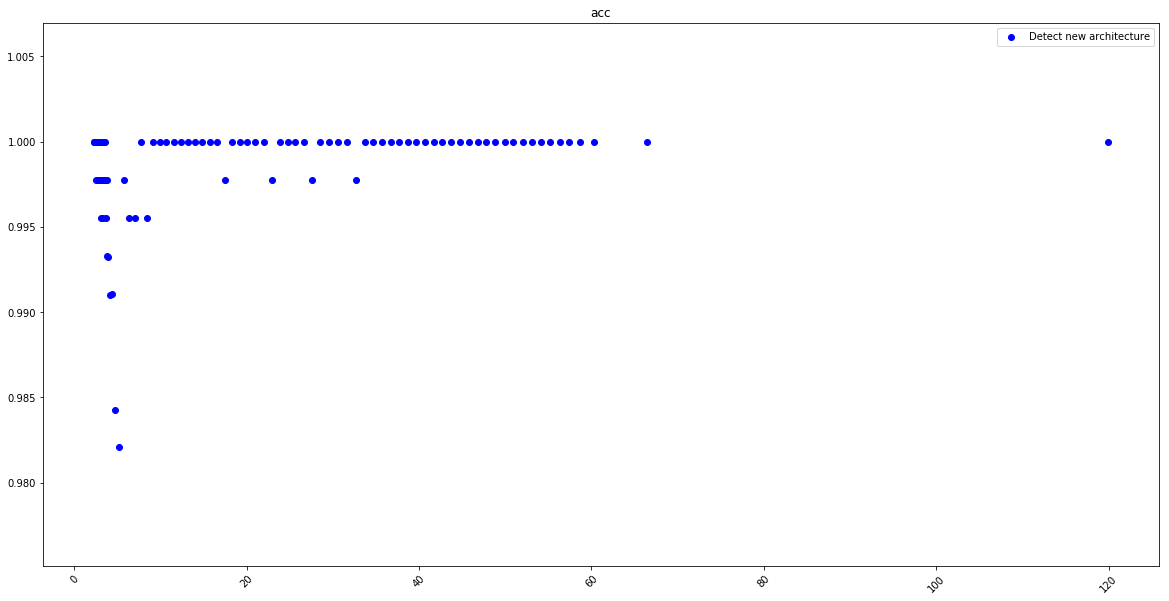

In [54]:
plot_metric(acc, 'acc')